In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [10]:
rat = pd.read_csv("ratings.csv")
print(ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [11]:
rat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [12]:
rat.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [13]:
mov = pd.read_csv("movies.csv")
mov.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
rat.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [17]:
print(len(rat))
print('Количество уникальных пользователей',len(rat['userId'].unique()))
print('Количество уникальных фильмов',len(rat['movieId'].unique()))

100836
Количество уникальных пользователей 610
Количество уникальных фильмов 9724


In [21]:
user_freq = rat[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


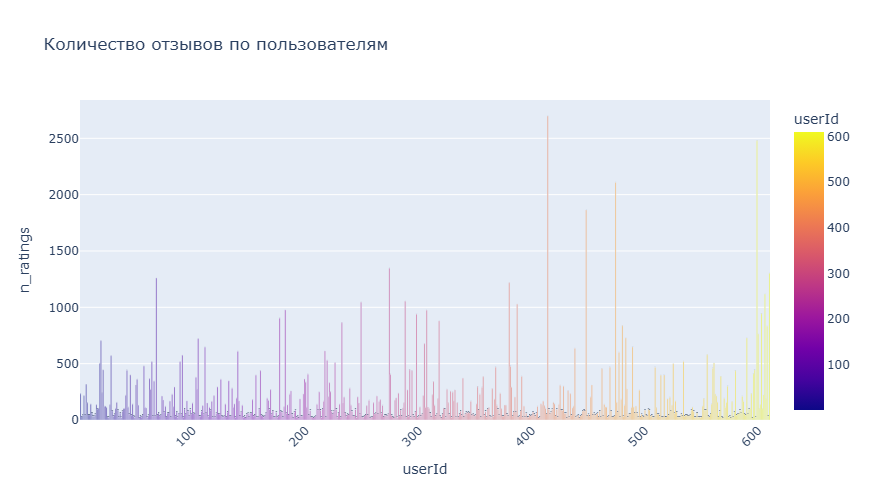

In [26]:
fig = px.bar(user_freq, x = 'userId', y = 'n_ratings', 
             text = 'n_ratings', color = 'userId', 
             title = 'Количество отзывов по пользователям')
fig.update_traces(textposition = 'outside')
fig.update_layout(width = 800, height = 500, xaxis_tickangle=-45, uniformtext_minsize = 8)
fig

In [38]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

#Индекс наименьшего по среднему рейтингу фильда
lowest_rating = mean_rating['rating'].idxmin()
mov.loc[mov['movieId'] == lowest_rating]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [39]:
highest_rating = mean_rating['rating'].idxmax()
mov.loc[mov['movieId'] == highest_rating]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [40]:
rat[rat['movieId'] == lowest_rating]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [42]:
rat[rat['movieId'] == highest_rating]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [50]:
movie_stats = rat.groupby('movieId')['rating'].agg(['count','mean'])
movie_stats

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
...,...,...
193581,1,4.000000
193583,1,3.500000
193585,1,3.500000


In [52]:
rm = movie_stats.merge(mov, on='movieId')
rm

,movieId,count,mean,title,genres
0,1,215,3.920930,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,110,3.431818,Jumanji (1995),Adventure|Children|Fantasy
2,3,52,3.259615,Grumpier Old Men (1995),Comedy|Romance
3,4,7,2.357143,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,49,3.071429,Father of the Bride Part II (1995),Comedy
...,...,...,...,...,...
9719,193581,1,4.000000,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9720,193583,1,3.500000,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9721,193585,1,3.500000,Flint (2017),Drama
9722,193587,1,3.500000,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## Создание матрицы пользовательских элементов

In [54]:
from scipy.sparse import csr_matrix

def create_matrix(df):
    
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
    
    user_mapper = dict(zip(np.unique(df['userId']), list(range(N))))
    movie_mapper = dict(zip(np.unique(df['movieId']), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]
    
    X = csr_matrix((df['rating'], (movie_index, user_index)), shape = (M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(rat)

## Анализ сходства фильмов

In [67]:
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False): 

    neighbour_ids = []
     
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids
 

movie_titles = dict(zip(mov['movieId'], mov['title']))
 
movie_id = 3
 
similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]
 
print(f"Since you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Since you watched Grumpier Old Men (1995)
Grumpy Old Men (1993)
Striptease (1996)
Nutty Professor, The (1996)
Twister (1996)
Father of the Bride Part II (1995)
Broken Arrow (1996)
Bio-Dome (1996)
Truth About Cats & Dogs, The (1996)
Sabrina (1995)
Birdcage, The (1996)


## Рекомендация фильма с учетом предпочтений пользователей

In [69]:
def recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10):
    df1 = rat[rat['userId'] == user_id]
     
    if df1.empty:
        print(f"User with ID {user_id} does not exist.")
        return
 
    movie_id = df1[df1['rating'] == max(df1['rating'])]['movieId'].iloc[0]
 
    movie_titles = dict(zip(mov['movieId'], mov['title']))
 
    similar_ids = find_similar_movies(movie_id, X, k)
    movie_title = movie_titles.get(movie_id, "Movie not found")
 
    if movie_title == "Movie not found":
        print(f"Movie with ID {movie_id} not found.")
        return
 
    print(f"Since you watched {movie_title}, you might also like:")
    for i in similar_ids:
        print(movie_titles.get(i, "Movie not found"))

In [79]:
user_id = 150
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)

Since you watched Twelve Monkeys (a.k.a. 12 Monkeys) (1995), you might also like:
Pulp Fiction (1994)
Terminator 2: Judgment Day (1991)
Independence Day (a.k.a. ID4) (1996)
Seven (a.k.a. Se7en) (1995)
Fargo (1996)
Fugitive, The (1993)
Usual Suspects, The (1995)
Jurassic Park (1993)
Star Wars: Episode IV - A New Hope (1977)
Heat (1995)
